# Practice Session PS05: Recommendation engines (Content-based)

Author: Tània Pazos Puig

E-mail: tania.pazos01@estudiant.upf.edu

Date: 30/10/2024

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). In this assignment we are going to use the 25M version, which was released in late 2019. We will use a sub-set containing only movies released in the 2000s, and only 20% of the users and all of their ratings.

**MOVIES** are described in `movies-2000s.csv` in the following format: `movieId,title,genres`.

**RATINGS** are contained in `ratings-2000s.csv` in the following format: `userId,movieId,rating`.

**TAGS** are contained in `tags-2000s.csv` in the following format: `userId,movieId,tag,timestamp`.

In [1]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

The following code loads the three datasets within three dataframes named `movies`, `ratings` and `tags`.

In [2]:
# Leave this code as-is

FILENAME_MOVIES = "data/movielens-25M-filtered/movies-2000s.csv"
FILENAME_RATINGS = "data/movielens-25M-filtered/ratings-2000s.csv"
FILENAME_TAGS = "data/movielens-25M-filtered/tags-2000s.csv"

In [3]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


Now, we add a column named `year` to the `movies` dataframe.

In [4]:
def yearof(title):
    # Find the year inside the parenthesis
    year = re.search(r'\((\d{4})\)', title)
    if year:
        # Return year as an integer
        return int(year.group(1))  
    return None

In [5]:
# Apply the created function to the 'title' column and create the 'year' column
movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1)

# Display the updated dataframe to check everything went correct
display(movies.head(5))

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


We can join `ratings_raw` and `movies` by the field `movie_id`, which they have in common. The code below join the datasets into a single dataframe called `ratings`. 

In [6]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')

display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


Now, we create a function `find_movies` to easily find movies that contain a given keyword in its title. For instance `find_movies("Barcelona", movies)` should print:

```
movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)
```

In [7]:
def find_movies(keyword, movies_df):
    keyword_lower = keyword.lower()
    
    # Find movies that contain the keyword in the title
    results = movies_df[movies_df['title'].str.lower().str.contains(keyword_lower, na=False)]
    
    for index, row in results.iterrows():
        print(f"movie_id: {row['movie_id']}, title: {row['title']}") 

In [8]:
find_movies("Barcelona", movies)

movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

To have a clear understanding of the data, it is key to know the distribution of the main variables. Next, we apply the function `describe()` to the field `rating` of the `ratings_raw` dataframe. 

In [9]:
# LEAVE AS-IS

ratings_raw['rating'].describe()

count    2.167702e+06
mean     3.533753e+00
std      1.067338e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

It is key to know how ratings are distributed. The following code plots a histogram of the ratings.

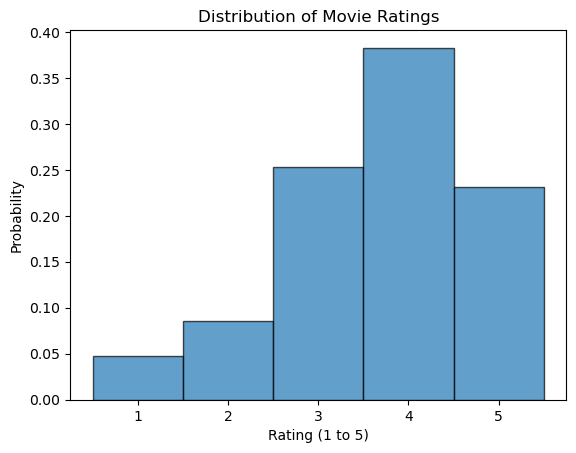

In [10]:
plt.hist(ratings_raw['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], density=True, alpha=0.7, edgecolor="black")

plt.xlabel('Rating (1 to 5)')
plt.ylabel('Probability')
plt.title('Distribution of Movie Ratings')

plt.show()

Now, we display a boxplot of movie ratings, which will allow us to identify outiler values.

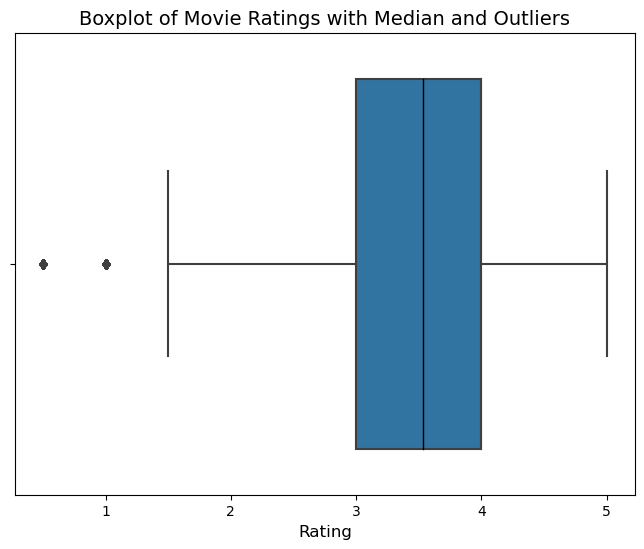

In [11]:
plt.figure(figsize=(8,6))

sns.boxplot(x=ratings_raw['rating'], showmeans=True, meanline=True, 
            meanprops={"color": "black", "ls": "-", "linewidth": 1})

plt.xlabel('Rating', fontsize=12)
plt.title('Boxplot of Movie Ratings with Median and Outliers', fontsize=14)

plt.show()

From the histogram, it can be seen that the distribution of ratings is left-skewed, with most of the ratings concentrated around high values. Indeed, nearly 40% of the ratings have a value of 4 in the scale from 1 to 5. This suggests that users are more inclined to give high ratings to movies. <br>
The boxplot shows that the central value -represented by the median- is close to 4, which confirms that the majority of movie ratings are favourable. We can easily identify a few outliers below the lower whisker, which correspond to very low ratings (close to 1). The interquartile range represented in blue emphasizes the idea that users generally rate movies positively.

Now, let us find out two extrema: movies with many good ratings and movies with many bad ratings.

For this, we will create two different dataframes: `good_ratings`, which will contain only the subset of rows of `ratings` that has *rating > 4.5*, and `bad_ratings` which will contain only the subset that has *rating < 1.5*. Then, we will print the title of the 10 movies with the most "good" ratings and the 10 movies with the most "bad" ratings, along with the count of ratings that meet the specified "good" or "bad" rating criteria for that movie.

In [12]:
good_ratings = ratings[ratings['rating'] > 4.5]
bad_ratings = ratings[ratings['rating'] < 1.5]

# Select the 10 most frequent titles in good_ratings
top_good_ratings = good_ratings['title'].value_counts().nlargest(10)
print("Top 10 Movies with Most Good Ratings:")
print(top_good_ratings)

# Select the 10 most frequent titles in bad_ratings
top_bad_ratings = bad_ratings['title'].value_counts().nlargest(10)
print("\nTop 10 Movies with Most Bad Ratings:")
print(top_bad_ratings)

Top 10 Movies with Most Good Ratings:
title
Lord of the Rings: The Fellowship of the Ring, The (2001)    1973
Lord of the Rings: The Return of the King, The (2003)        1806
Lord of the Rings: The Two Towers, The (2002)                1693
Memento (2000)                                               1255
Gladiator (2000)                                             1156
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1116
Eternal Sunshine of the Spotless Mind (2004)                  959
Spirited Away (Sen to Chihiro no kamikakushi) (2001)          862
Shrek (2001)                                                  734
Kill Bill: Vol. 1 (2003)                                      718
Name: count, dtype: int64

Top 10 Movies with Most Bad Ratings:
title
Battlefield Earth (2000)                                     277
Charlie's Angels (2000)                                      236
Scary Movie (2000)                                           221
Star Wars: Episode II - Attack 

On the one hand, in the Top 10 Movies with Most Good Ratings, the *Lord of the Rings* trilogy occupies the top three positions. This indicates that these movies have a large fanbase. In the list, we observe other well-known movies such as *Gladiator*, *Amelie*, or *Kill Bill*. <p>
    On the other hand, the Top 10 Movies with Most Bad Ratings includes films that were widely disliked (*Battlefield Earth*,  *Charlie's Angels* and *Scary Movie*). Paradoxically, the list also contains two *Lord of the Rings* films -*The Return of the King* and *The Fellowship of the Ring*- which appeared in the Top 10 Movies with Most Good Ratings. This suggests that often, movies that are highly appreciated by the public can also attract significant criticism. 

## 2.2. Genres distribution

Tipically, a movie genre (e.g., "musical", "action", "romance") is one of the most important descriptors for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. <br> Next, we count the number of different genres in the dataset, including `(no genres listed)` and verify that there are 20 distinct genres.

In [13]:
# Use a set to automatically avoid duplicates
all_genres = set()

# Loop through each genre in the 'genres' column
for genres in movies['genres']:
    # Split genres by | and add them to the set
    for genre in genres.split('|'):
        all_genres.add(genre)
        
unique_genres_list = list(all_genres)

# Verify that there are 20 genres
n = len(unique_genres_list)
assert(n == 20)

Now, we will print the list of the genres in the dataset sorted from the most frequent to the least frequent. 

The output will be contained in the dataframe `genre_count`.

In [14]:
def count_genres(movies):
    # Dictionary to count occurrences for each genre
    genre_count_dict = {}
    
    # Loop through each genre in the 'genres' column
    for genres in movies['genres']:
        # Split genres by | and update counts in the dictionary
        for genre in genres.split('|'):
            if genre in genre_count_dict:
                genre_count_dict[genre] += 1
            else:
                genre_count_dict[genre] = 1
                
    # Create a new dataframe genre_count
    genre_count = pd.DataFrame(list(genre_count_dict.items()), columns=['genre', 'count'])
    
    # Sort it in descending order
    genre_count = genre_count.sort_values(by='count', ascending=False).reset_index(drop=True)

    return genre_count

In [15]:
genre_count = count_genres(movies)
display(genre_count.head(5))

,genre,count
0,Drama,13666
1,Comedy,8898
2,Thriller,5437
3,Documentary,4473
4,Action,3901


In order to inspect the distribution of genres, we will create a horizontal barplot in which bars are horizontal, genres are in the Y axis from most common (top) to least common (bottom), and the horizontal length of the bar indicates the number of movies. <br>
We will produce two bar plots: one for movies filmed on 2005 or before, and another for movies filmed on 2016 or later.

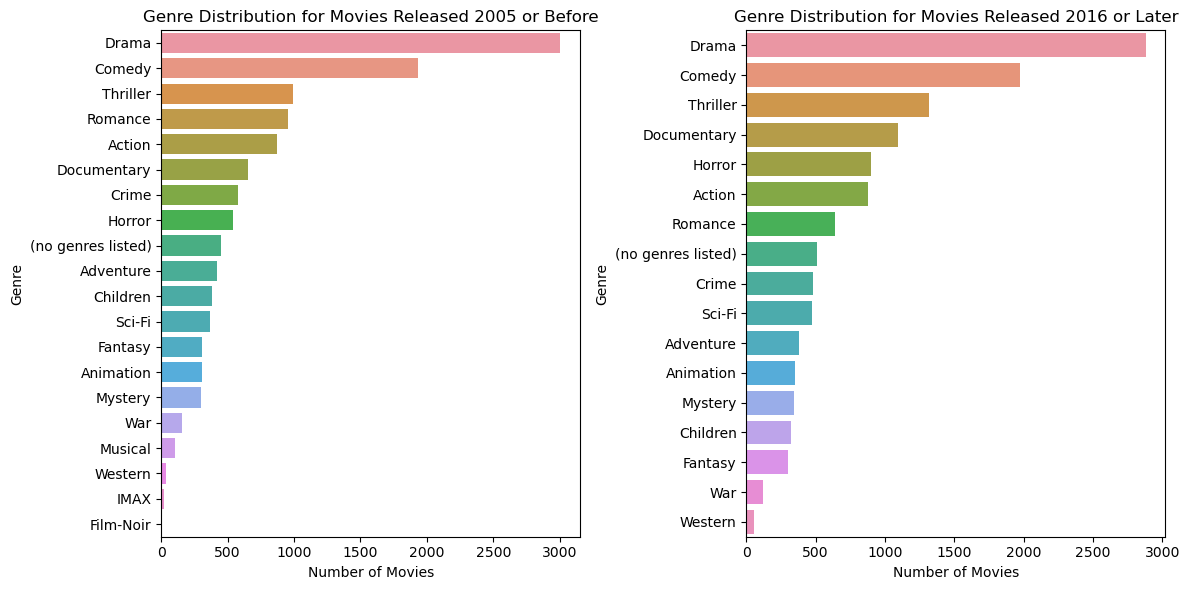

In [16]:
# Split dataframe movies into two based on year column
movies_before_2006 = movies[movies['year'] <= 2005]
movies_after_2015 = movies[movies['year'] >= 2016]

genre_count_before = count_genres(movies_before_2006)
genre_count_after = count_genres(movies_after_2015)

# Create horizontal bar plots
plt.figure(figsize=(12, 6))

# Bar plot for movies filmed on or before 2005
plt.subplot(1, 2, 1)
sns.barplot(data=genre_count_before, x='count', y='genre', orient='h')
plt.title('Genre Distribution for Movies Released 2005 or Before')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

# Bar plot for movies filmed on or after 2016
plt.subplot(1, 2, 2)
sns.barplot(data=genre_count_after, x='count', y='genre', orient='h')
plt.title('Genre Distribution for Movies Released 2016 or Later')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

Firstly, the top three genres of films before 2006 -Drama, Comedy, and Thriller- have maintained their prominence after 2016, with a notable increase in the number of Thriller films. <p> However, it's important to point out that the representation of Romantic films significantly decreased after 2015, while Documentaries gained importance during the same period. <p> Additionally, some genres that had minor representation before 2006, such as Musical, IMAX, and Film-Noir, completely lost their presence after 2015. This loss was not compensated by the emergence of new genres.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

Next, we will use TF-IDF to weight infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres. <p>
    First, we will break up the genre string into a string array and create a new column `genres_arr` in dataframe `movies` that will contain the genres splitted in character "|".

In [17]:
# Create the genres_arr column by splitting genres by |
# Ensure this column has no NaN values with fillna
movies['genres_arr'] = movies['genres'].fillna('').astype(str).str.split('|')

In [18]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


We will now work with a smaller part of the data: `movies_filtered` will contain all the movies filmed on 2016 or later.

The code below uses the [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute tf-idf vectors on the genres. We will set `ngram_range=(1,2)` to consider one- and two-word genres and store the resulting vectors in `tfidf_matrix`.

In [19]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2016]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


In [20]:
# Since TfidVectorizer expects a list of strings rather than a list of lists
# Join lists of genres_arr into a single array 
movies_filtered['genres_str'] = movies_filtered['genres_arr'].apply(lambda x: ' '.join(x))

# Initialize with the specified ngram range
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))

# Apply the vectorizer on the genres string column
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres_str'])

# Verify the shape of the tfidf_matrix
print("Shape of tfidf_matrix:", tfidf_matrix.shape)

Shape of tfidf_matrix: (7890, 130)


## 3.2. Calculate most similar movies

The code below computes the similarity matrix between each pair of movies based on their genre.

In [21]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


It is easy at this point to confuse movie_ids with row numbers. The following code shows how to obtain a row/column in this similarity matrix, and then how to go back to movie_ids from row/column numbers.

In this example, we ask for the similarities of all movies to movie with id 122904 which is "Deadpool (2016)".

In [22]:
# Leave this code as-is

# Create an index to convert from row numbers to movie_id
# movies_filtered.index are row numbers
# movies_filtered["movie_id"] are movies ids
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
# Second argument is a matrix with similarity scores for every pair of movies
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row and print all other movies with 
    # their similarity scores to that movie
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

Next, we define a function `genre_content_based_recommendations` that uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie id.

In [23]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):
    # Determine the row index of the  specified movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get similarity scores for that movie
    sim_scores = list(similarities[index_source])
    
    # Create a list of (index, similarity) tuples
    enumerated_similarities = list(enumerate(sim_scores))
    
    # Sort in descending order to find the top-k
    sorted_similarities = sorted(enumerated_similarities, key=lambda x: x[1], reverse=True)
    
    recommendations = []
    
    for (index_target, similarity) in sorted_similarities:
        if movies_filtered.iloc[index_target].movie_id != movie_id:  # Skip the specified movie
            # Get movie_id, title, and genres for each recommended movie
            rec_movie_id = movies_filtered.iloc[index_target].movie_id
            title = movies_filtered.iloc[index_target].title
            genres = movies_filtered.iloc[index_target].genres
            
            recommendations.append({
                'movie_id': rec_movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            })
        
        # Stop once we have num_movies recommendations
        if len(recommendations) == num_movies:
            break
    
    # Return a dataframe of the recommendations
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In order to test our function, we will print the top 10 recommendations for "Pirates of the Caribbean" (movie_id=122896) and "Midsommar" (movie_id=201646) based exclusively on their genre.

In [31]:
pirates_recommendations = genre_content_based_recommendations(122896, movies_filtered, cosine_sim, num_movies=10)
print("Top 10 Recommendations for 'Pirates of the Caribbean':")
display(pirates_recommendations)

midsommer_recommendations = genre_content_based_recommendations(201646, movies_filtered, cosine_sim, num_movies=10)
print("\nTop 10 Recommendations for 'Midsommar':")
display(midsommer_recommendations)

Top 10 Recommendations for 'Pirates of the Caribbean':


,similarity,movie_id,title,genres
0,1.0,122888,Ben-hur (2016),(no genres listed)
1,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
2,1.0,138212,Spectral (2016),(no genres listed)
3,1.0,141131,Guardians (2016),(no genres listed)
4,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
5,1.0,150724,Army Dog (2016),(no genres listed)
6,1.0,151461,Fitoor (2016),(no genres listed)
7,1.0,151593,Martyrs (2016),(no genres listed)
8,1.0,152037,Grease Live (2016),(no genres listed)
9,1.0,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed)



Top 10 Recommendations for 'Midsommar':


,similarity,movie_id,title,genres
0,1.000000,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.000000,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.000000,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.000000,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.000000,184067,Without Name (2017),Drama|Horror|Mystery
5,1.000000,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.000000,192291,Rift (2017),Drama|Horror|Mystery
7,1.000000,201739,Wounds (2019),Drama|Horror|Mystery
8,1.000000,202225,Something (2018),Drama|Horror|Mystery
9,0.856332,158619,The Faith of Anna Waters (2016),Drama|Horror|Mystery|Thriller


Next, we will estimate the average precision of our recommender system. To do so, we will print the list of top 10 recommendations for three movies we are familiar with -"Parasite (2019)", "La La Land (2016)" and "Your Name. (2016)"- and manually identify the percentage of recommended movies we consider relevant. Then, we will compute the average precision across the three lists.

In [25]:
movie1_title = movies_filtered.loc[movies_filtered['movie_id'] == 202439, 'title'].values[0]
movie1_recommendations = genre_content_based_recommendations(202439, movies_filtered, cosine_sim, num_movies=10)
print(f"Recommendations for '{movie1_title}':")
display(movie1_recommendations)

movie2_title = movies_filtered.loc[movies_filtered['movie_id'] == 164909, 'title'].values[0]
movie2_recommendations = genre_content_based_recommendations(164909, movies_filtered, cosine_sim, num_movies=10)
print(f"Recommendations for '{movie2_title}':")
display(movie2_recommendations)

movie3_title = movies_filtered.loc[movies_filtered['movie_id'] == 163134, 'title'].values[0]
movie3_recommendations = genre_content_based_recommendations(163134, movies_filtered, cosine_sim, num_movies=10)
print(f"Recommendations for '{movie3_title}':")
display(movie3_recommendations)

Recommendations for 'Parasite (2019)':


,similarity,movie_id,title,genres
0,1.0,151319,Notias (2016),Comedy|Drama
1,1.0,152547,Love Records (2016),Comedy|Drama
2,1.0,155659,Florence Foster Jenkins (2016),Comedy|Drama
3,1.0,157268,Don't Think Twice (2016),Comedy|Drama
4,1.0,157318,Perfect Strangers (2016),Comedy|Drama
5,1.0,157385,Geezer (2016),Comedy|Drama
6,1.0,159077,The Meddler (2016),Comedy|Drama
7,1.0,159163,The Other Side of the Wind (2016),Comedy|Drama
8,1.0,160201,La pazza gioia (2016),Comedy|Drama
9,1.0,160533,Adult Life Skills (2016),Comedy|Drama


Recommendations for 'La La Land (2016)':


,similarity,movie_id,title,genres
0,1.0,157140,Dreamland (2016),Comedy|Drama|Romance
1,1.0,157290,Suntan (2016),Comedy|Drama|Romance
2,1.0,157328,Kadhalum Kadanthu Pogum (2016),Comedy|Drama|Romance
3,1.0,158882,All Yours (2016),Comedy|Drama|Romance
4,1.0,158888,Dater's Handbook (2016),Comedy|Drama|Romance
5,1.0,158896,Love's Complicated (2016),Comedy|Drama|Romance
6,1.0,159193,CafÃ© Society (2016),Comedy|Drama|Romance
7,1.0,159415,Swiss Army Man (2016),Comedy|Drama|Romance
8,1.0,161240,Looking: The Movie (2016),Comedy|Drama|Romance
9,1.0,165115,My Blind Brother (2016),Comedy|Drama|Romance


Recommendations for 'Your Name. (2016)':


,similarity,movie_id,title,genres
0,1.000000,204158,Weathering with You (2019),Animation|Drama|Fantasy|Romance
1,0.817178,204610,Children of the Sea (2019),Animation|Drama|Fantasy
2,0.808528,168788,A Sunday Kind of Love (2016),Drama|Fantasy|Romance
3,0.808528,174499,Vanishing Time: A Boy Who Returned (2016),Drama|Fantasy|Romance
4,0.808528,179293,November (2017),Drama|Fantasy|Romance
5,0.808528,192903,"Tonight, At the Movies (2018)",Drama|Fantasy|Romance
6,0.808528,195465,Heart of Stone (2016),Drama|Fantasy|Romance
7,0.808528,196283,Ice (2016),Drama|Fantasy|Romance
8,0.744460,176063,Phillauri (2017),Comedy|Drama|Fantasy|Romance
9,0.671419,179511,Emerald Green (2016),Adventure|Drama|Fantasy|Romance


For "Parasite (2019)", we considered that none of the recommended movies were meaninful. Hence, the percentage of relevant movies for this list of recommendations is 0%.

For "La La Land (2016)", "Dreamland (2016)", "Café Society (2016)" and "Looking: The Movie (2016)" were considered relevant recommendations, leading to a percentage of relevant movies of approximately 33.33%.

Lastly, for "Your Name. (2016)" we considered meaningul recommendations "Weathering with You (2019)", "Children of the Sea (2019)", "Vanishing Time: A Boy Who Returned (2016)", "Tonight, At the Movies (2018)". Thus, the percentage of relevant movies for this list of recommendations is 40%.

As a result, the average precision across the three lists of recommendations is 24.44%. 

Given the results, it is clear that our content-based recommender system lacks precision. 

One way to improve these content-based recommendations is to incorporate additional features like year of release to make the recommender system more personalized. Indeed, the fact that the similarity between two movies is based solely on genres causes that recommendations are too general.

Furthermore, we could incorporate average movie ratings into the recommendation criteria. This would mean adding a preference factor for movies with higher average ratings, thereby increasing the chances that a user will enjoy the recommended movie.

Lastly, another approach to enchance our recommendations while still using only the "genres" feature is to assign weights to genres based on their relevance in a certain movie. As a result, the obtained similarities would be more representative of each movie's unique combination of genres.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>